<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/4%EC%A3%BC%EC%B0%A8_mhealth_cnn%2Clstm%2Ccnn%2Blstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (오늘 실습과제)

Mhealth dataset으로 인간행동 분류하기

일단 데이터 읽어서 subject 번호가 컬럼면에 포함된 통합 data frame 만들고 CNN, LSTM, CNN-LSTM 해보기.

1. LLM(sLLM)을 제외한 어떤 모델을 써도 가능. 단 라이브러리 import 불가. 모델의 풀 소스가 있어야 함.

 2. 10명을 1+2, 3+4, 4+5,.... 5개그룹으로 나눠 2명씩 테스트 데이터로 하면서 cross validation.

 3. 데이터 증대는 안됨.

4. 오직 모델로만 성능 향상

5. 상위 30%씩 차등.

6. 성적에 반영

7. 11월15일까지. Github게시

교차 평가로 평균 F1 기준.

8. 본인이 완벽하게 소스 및 모델을 설명할 수 있어야 함. GPT를 쓰던 뭘 쓰던 그건 상관안함. 재현성이 보장되어야 함.
--------------------------------------------------------------------------
--------------------------------------------------------------------------

## 데이터설명
📌 Dataset Summary

Subjects: 10명 (다양한 프로필의 자원자)

Activities: 12개

Sensors: 3개 (가슴, 오른쪽 손목, 왼쪽 발목 → elastic strap으로 고정)

측정 정보:

Acceleration (가속도)

Gyroscope (회전율)

Magnetometer (자기장 방향)

Chest sensor: 2-lead ECG 추가 (활동 인식에는 사용 안 함, 향후 연구용)

Sampling Rate: 50 Hz

환경: Out-of-lab, 제약 없이 자유롭게 활동 수행 (단, 최선을 다해 실행)

📌 Activity Set (12 classes)

정적 활동: Standing still, Sitting, Lying down

일상/이동 활동: Walking, Climbing stairs, Cycling

운동/역동적 활동: Jogging, Running, Jump front & back

반복 동작: Waist bends, Arm elevation, Knees bending

📌 특징

ECG 포함: 운동 중 심전도 기록 → 부정맥, 심박수 모니터링, 운동 효과 분석 가능

다양성 확보:

동작 강도 차이 (예: Sitting vs. Running)

속도 차이 (예: Walking vs. Jogging)

다른 신체 부위 동작 (예: Arm elevation vs. Knees bending)

실생활 반영: 실제 환경에서 수행되어 일반화 성능 높음

In [1]:
import pandas as pd
import glob
import numpy as np

# 1. 파일 리스트
files = sorted(glob.glob("/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET/mHealth_subject*.log"))

# 2. 컬럼 정의
columns = [
    "chest_acc_x","chest_acc_y","chest_acc_z",
    "ecg_1","ecg_2",
    "chest_gyro_x","chest_gyro_y","chest_gyro_z",
    "chest_mag_x","chest_mag_y","chest_mag_z",
    "ankle_acc_x","ankle_acc_y","ankle_acc_z",
    "ankle_gyro_x","ankle_gyro_y","ankle_gyro_z",
    "ankle_mag_x","ankle_mag_y","ankle_mag_z",
    "wrist_acc_x","wrist_acc_y","wrist_acc_z",
    "label"
]

# 3. 각 파일 읽어서 subject_id 추가
dfs = []
for i, file in enumerate(files, start=1):
    df = pd.read_csv(file, sep="\s+", header=None)
    df.columns = columns
    df["subject_id"] = i
    dfs.append(df)

# 4. 통합 DataFrame
data = pd.concat(dfs, ignore_index=True)


<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4155912323.py:24: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, sep="\s+", header=None)


In [2]:
def create_windows(df, frame_size=100, hop_size=50):
    X, y = [], []
    data_values = df.drop(["label", "subject_id"], axis=1).values
    labels = df["label"].values
    for i in range(0, len(data_values)-frame_size, hop_size):
        X.append(data_values[i:i+frame_size])
        y.append(labels[i+frame_size-1])  # 마지막 시점 label
    return np.array(X), np.array(y)


In [3]:
!pip install tensorflow

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM

n_classes = data["label"].nunique()
n_features = data.drop(["label","subject_id"],axis=1).shape[1]
timesteps = 100  # frame_size

# CNN 모델
def build_cnn():
    model = Sequential([
        Conv1D(64, 3, activation="relu", input_shape=(timesteps, n_features)),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# LSTM 모델
def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=(timesteps, n_features)),
        Dense(64, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# CNN-LSTM 모델
def build_cnn_lstm():
    model = Sequential([
        Conv1D(64,3, activation="relu", input_shape=(timesteps, n_features)),
        MaxPooling1D(2),
        LSTM(64),
        Dense(64, activation="relu"),
        Dense(n_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [5]:
subjects = np.arange(1,11)
folds = [(subjects[i], subjects[i+1]) for i in range(0,10,2)]

for fold_idx, test_subjects in enumerate(folds, start=1):
    # Train/Test 분리
    test_data = data[data["subject_id"].isin(test_subjects)]
    train_data = data[~data["subject_id"].isin(test_subjects)]

    # 윈도우 생성
    X_train, y_train = create_windows(train_data, frame_size=timesteps, hop_size=50)
    X_test, y_test = create_windows(test_data, frame_size=timesteps, hop_size=50)

    print(f"\n=== Fold {fold_idx}: Test subjects {test_subjects} ===")
    print("Samples:", X_train.shape[0], "(train)", X_test.shape[0], "(test)")

    # 모델 선택
    model = build_cnn()  # CNN, LSTM, CNN-LSTM 중 선택
    # model = build_lstm()
    # model = build_cnn_lstm()

    # 학습
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

    # 평가
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {acc:.4f}")



=== Fold 1: Test subjects (np.int64(1), np.int64(2)) ===
Samples: 19122 (train) 5190 (test)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6515 - loss: 2.9587
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7263 - loss: 0.8392
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7615 - loss: 0.6289
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7722 - loss: 0.5413
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7863 - loss: 0.4670
Test Accuracy: 0.7514

=== Fold 2: Test subjects (np.int64(3), np.int64(4)) ===
Samples: 19260 (train) 5052 (test)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5644 - loss: 2.7111
Epoch 2/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7734 - loss: 0.5618
Epoch 3/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8130 - loss: 0.4208
Epoch 4/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8336 - loss: 0.3710
Epoch 5/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8481 - loss: 0.3357
Test Accuracy: 0.7876

=== Fold 3: Test subjects (np.int64(5), np.int64(6)) ===
Samples: 19583 (train) 4729 (test)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6656 - loss: 3.4864
Epoch 2/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7384 - loss: 0.8381
Epoch 3/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7535 - loss: 0.6381
Epoch 4/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7797 - loss: 0.4981
Epoch 5/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8112 - loss: 0.4138
Test Accuracy: 0.7289

=== Fold 4: Test subjects (np.int64(7), np.int64(8)) ===
Samples: 20258 (train) 4054 (test)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6335 - loss: 3.7389
Epoch 2/5
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7529 - loss: 0.6189
Epoch 3/5
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7847 - loss: 0.4818
Epoch 4/5
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8070 - loss: 0.4194
Epoch 5/5
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8305 - loss: 0.3585
Test Accuracy: 0.7763

=== Fold 5: Test subjects (np.int64(9), np.int64(10)) ===
Samples: 19030 (train) 5282 (test)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6612 - loss: 3.4815
Epoch 2/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7456 - loss: 0.6920
Epoch 3/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7629 - loss: 0.5526
Epoch 4/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8003 - loss: 0.4649
Epoch 5/5
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8138 - loss: 0.4120
Test Accuracy: 0.7669


595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
=== Train Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     13511
           1       0.75      0.43      0.55       490
           2       0.74      0.95      0.83       491
           3       0.80      1.00      0.89       495
           4       0.84      0.53      0.65       492
           5       0.76      0.71      0.73       494
           6       0.61      0.64      0.63       465
           7       0.64      0.83      0.73       472
           8       0.68      0.71      0.69       477
           9       0.90      0.80      0.85       493
          10       0.00      0.00      0.00       493
          11       0.40      0.94      0.56       492
          12       0.00      0.00      0.00       165

    accuracy                           0.84     19030
   macro avg       0.62      0.65      0.62     19030
weighted avg       0.83      0.84      0.83     19030



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


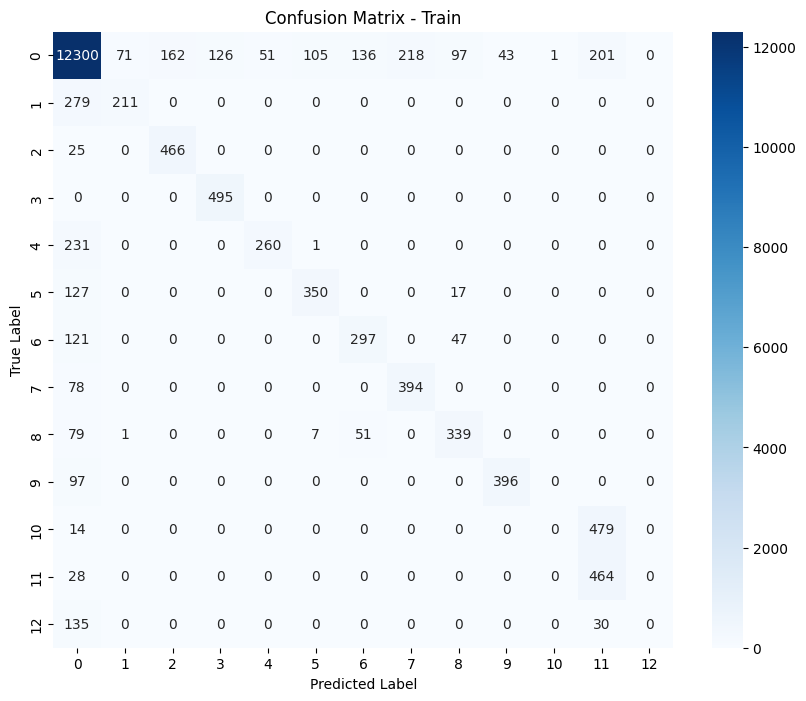

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
=== Test Classification Report ===
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3931
           1       0.50      0.48      0.49       122
           2       0.37      0.50      0.43       123
           3       0.67      1.00      0.81       124
           4       0.47      0.34      0.39       122
           5       0.53      0.68      0.59       124
           6       0.70      0.39      0.50       100
           7       0.56      0.47      0.51       118
           8       0.51      0.66      0.58       110
           9       0.58      0.43      0.50       122
          10       0.00      0.00      0.00       123
          11       0.38      1.00      0.55       122
          12       0.00      0.00      0.00        41

    accuracy                           0.77      5282
   macro avg       0.47      0.52      0.48      5282
weighted avg       0.76      0.77      0.76      5282



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


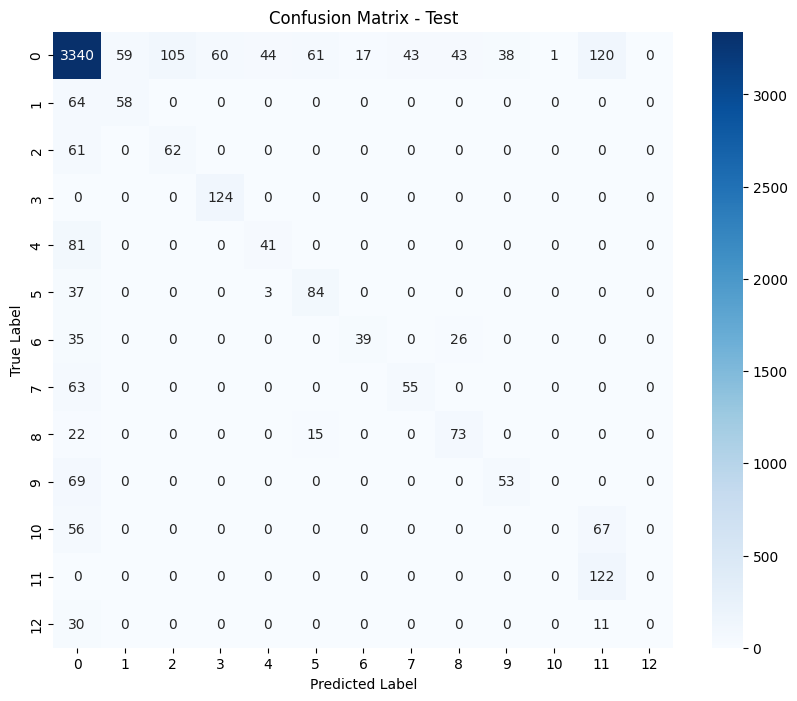

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ======================
# 1. Train 데이터 평가
# ======================
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

print("=== Train Classification Report ===")
print(classification_report(y_train, y_pred_train))

cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(10,8))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# ======================
# 2. Test 데이터 평가
# ======================
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

print("=== Test Classification Report ===")
print(classification_report(y_test, y_pred_test))

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10,8))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
